In [1]:
import pandas as pd
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt
import sklearn as sk
import warnings
import seaborn as sns
import itertools
from collections import Counter

############################################
from imblearn.datasets import fetch_datasets
from imblearn.pipeline import make_pipeline as make_pipeline_imb 
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE

#####################
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
################
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
#################

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
##################

warnings.filterwarnings("ignore")

% matplotlib inline 

ModuleNotFoundError: No module named 'imblearn'

# 1. Data Query

## a. List the top 5 user_id which had the highest number of CTR filed during in any 7 days window period. 

### I tuned the transactions table (csv file) to make it work for the current case. Although the query is written with attribute names given in the schema I provide instructions how to make it work for the test case.

In [ ]:
trans = pd.read_csv('transaction_data.csv', date_parser=['timestamp']) 
# Replace timestamp by date for the current csv file to work.

## Steps taken are as follows: 


  

In [ ]:
### Select requisite columns only 

df = trans[['User_id','timestamp','CTR']] 

# Convert CTR from binary to Integer. Assuming CTR is binary as provided in schema. 

df.CTR = df.CTR.astype(int)

# Sort the values then groupby on User_id
df.sort_values(by=['timestamp'],inplace = True)


In [ ]:
### Create a date only column



df['DateOnly'] = df['timestamp']
# Set the created date only column as Datetime Index
df1 = df.set_index(pd.DatetimeIndex(df['DateOnly']))

# Create a new table that shows rolling sum of CTR column for a window of 7 days 
# for the User_id groups

df2 = df1.groupby(by = [df1['User_id']]).resample("1d").sum().fillna(0).rolling(window=7, min_periods=1)['CTR'].sum()

# Reset index
df2  = df2.reset_index()

# Do a groupby on User_id and find the maxvalues then select the user_ids for the 5 largest sums 
df2.groupby('User_id')['CTR'].max().reset_index().nlargest(5, 'CTR')['User_id']

## b. List top 5 user_id which had the largest amount of incoming amount over any 30 day period exceeding \$1,000,000? 

<font color='red'>  **Note: I was confused by the wording of this particular question. Is it total incoming over 30 day period ? **</font>

In [ ]:
df = trans[['User_id','timestamp','amount','activity_type']]
# Pivot on the activity type
df = df.pivot_table(index=['User_id','timestamp'] , columns = 'activity_type', values = 'amount', fill_value = 0).reset_index()

### Create a date only column
df['DateOnly'] = df['timestamp']
# Set the created date only column as Datetime Index
df1 = df.set_index(pd.DatetimeIndex(df['DateOnly']))
# Create a new table that shows rolling sum of Incoming amount column for a window of 30 days 
# for the User_id groups
df2 = df1.groupby(by = [df1['User_id']]).resample("1d").sum().fillna(0).rolling(window=30, min_periods=1)['Incoming'].sum()
df2 = df2.reset_index()
# Do a groupby on User_id and find the max values then select the user_ids for the 5 largest sums 
df3 = df2.groupby('User_id')['Incoming'].max().reset_index().nlargest(5, 'Incoming') 
# Select the values greater than 1000000: I changed to 10000 in test case as there are no such Incoming amount in
# the given csv file which are greater than 1000000.
df3 = df3[df3['Incoming'] > 10000]
df3['User_id']

## Question 2: Modeling

## a) For a not ‘Male’ customer, what is the most important features in predicting likelihood of customer doing cryptocurrency transaction? 

<font color='blue'> 
For not male the covariate male X = 0. 
    
We first standardize the coefficients for logistic regression as they are not in the same scale [1], using the following formula - 

      $$Coefficient^{*} = \frac{Coefficient \times SE}{\frac{\pi}{\sqrt{3}}}$$
</font>
    
    
    
    
    
[1]  Menard, Scott. "Six approaches to calculating standardized logistic regression coefficients." The American Statistician 58.3 (2004): 218-223.    

In [171]:
def standardize_coefficient(Coefficient, SE):
    
    return Coefficient * SE  / (np.pi/np.sqrt(3))

In [172]:
d = {'variable' : ['Male','AB','Age','Age_sq','Investor','Works_at_Y','Constant'], 'coefficients' : [2.45, -0.109, -0.0135, 0.0001, 3.21, -5.12, 2.8], 'se' : [0.12, 0.041, 0.00096, 0.000029, 0.67, 0.399, 0.584]}
df = pd.DataFrame(data=d)



In [173]:
standardized_coef = []

df['standardized_coef'] = df.apply(lambda row : standardize_coefficient(row['coefficients'],row['se']), axis = 1)

df['|std_coef|'] = np.abs(df.standardized_coef.values)

In [174]:
df.sort_values('|std_coef|', ascending=False, inplace=True)

In [175]:
df.head(10)

variable  coefficients        se  standardized_coef    |std_coef|
4    Investor        3.2100  0.670000       1.185743e+00  1.185743e+00
5  Works_at_Y       -5.1200  0.399000      -1.126299e+00  1.126299e+00
6    Constant        2.8000  0.584000       9.015330e-01  9.015330e-01
0        Male        2.4500  0.120000       1.620907e-01  1.620907e-01
1          AB       -0.1090  0.041000      -2.463889e-03  2.463889e-03
2         Age       -0.0135  0.000960      -7.145222e-06  7.145222e-06
3      Age_sq        0.0001  0.000029       1.598854e-09  1.598854e-09

<font color='blue'> 
We can directly observe the values, rank them from high to low (omitting the + or – sign) and report on order of importance.
</font>

In [176]:
np.max(np.abs(df.standardized_coef))

1.185743055383648

<font color='blue'> 
Thus <font color='red'> **Investor**</font> is the most important feature, followed by <font color='red'> **Works_at_Y**</font> .
</font>

## b) How do we interpret the difference in probability using cryptocurrency exchange between users of different ages? 

<font color='blue'> 
The sign of the age coefficient is negative hence as **Age** of customers increase, it is expected that the usage of crypotocurrency will decrease. But due to the nature of the logistic function this won't have any effect, outside a particular range of values. We can experimentally check the effects. For simplicity we assume only <font color='red'> **Investor**</font> and <font color='red'> **Works_at_Y**</font> are the two other covariates. The dummy values are (0 and 1) only for <font color='red'> **Investor**</font> and <font color='red'> **Works_at_Y**</font>. We also take the **Age_sq** as it  has a positive coefficient. 
</font>

We get the formula as $$y = log \frac{p}{1-p} = const + \beta_0 Investor + \beta_1 * Works\_at\_Y + \beta_2 * Age + \beta_3 * Age\_sq$$
    and $$p = \frac{exp(p)}{exp(p) + 1}$$ 

### For Investor = 0 and Works_at_Y = 0

In [177]:
df.coefficients[2]

-0.0135

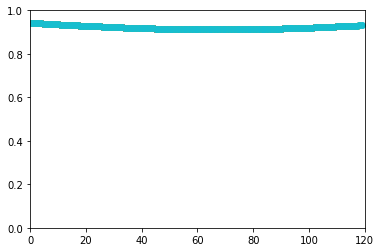

In [178]:
fig = plt.figure()
plt.axis([ 0, 120, 0, 1])
X = list()
Y = list()
for i in range(120):
    y =  2.8 -0.0135*i +0.0001*i**2
    
    X.append(i)
    Y.append(np.exp(y)/(np.exp(y) + 1))
    plt.scatter(X,Y)

### For Investor = 1 and Works_at_Y = 1

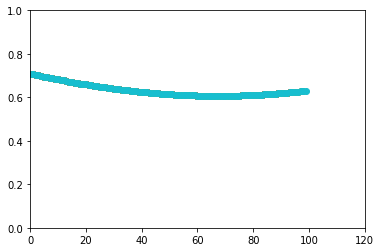

In [179]:
fig = plt.figure()
plt.axis([0, 120, 0, 1])
X = list()
Y = list()
for i in range(0,100):
    y = df.coefficients[6] + df.coefficients[4] * 1 + df.coefficients[5]* 1 + df.coefficients[2]*i   +0.0001*i**2
    X.append(i)
    Y.append(np.exp(y)/(np.exp(y) + 1))
    plt.scatter(X,Y)

### For Investor = 0 and Works_at_Y = 1

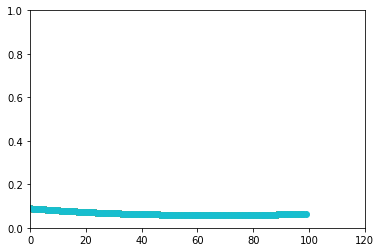

In [180]:
fig = plt.figure()
plt.axis([0, 120, 0, 1])
X = list()
Y = list()
for i in range(0,100):
    y = df.coefficients[6] + df.coefficients[4] *0 + df.coefficients[5]* 1 + df.coefficients[2]*i   +0.0001*i**2
    
    X.append(i)
    Y.append(np.exp(y)/(np.exp(y) + 1))
    plt.scatter(X,Y)

### For Investor = 1 and Works_at_Y = 0

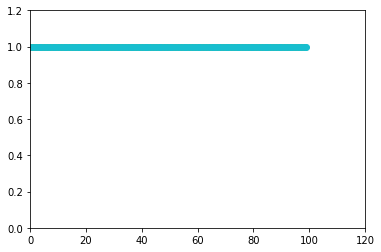

In [181]:
fig = plt.figure()
plt.axis([0, 120, 0, 1.2])
X = list()
Y = list()
for i in range(0,100):
    y = df.coefficients[6] + df.coefficients[4] *1 + df.coefficients[5]* 0 + df.coefficients[2]*i  + df.coefficients[3]*i**2
    
    X.append(i)
    Y.append(np.exp(y)/(np.exp(y) + 1))
    plt.scatter(X,Y)

<font color='red'>**Summarizing the results from the above simulations, we see that it starts   with  in age and then increases again. We   cannot infer  cogent conclusions or   any correlation of Age with the probability of cryptocurrency usage. This analysis is based on the parameters provided only.**</font> 

# Q3. Data Analysis


In [2]:
data = pd.read_csv('transaction_data.csv', parse_dates=   ['date'])
data.head()

Unnamed: 0  user_id       date     trx_type activity_type  counter_party  \
0           0  1001517 1971-06-17          ACH      Incoming        6504238   
1           1  1001517 1971-12-13          ACH      Incoming        6504238   
2           2  1001517 1971-09-13          ACH      Outgoing        2501016   
3           3  1001517 1971-12-13          ACH      Outgoing        7328482   
4           4  1001517 1971-02-05  Credit_Card      Incoming        6366609   

         amount user_phone_number counter_party_phone_number  Y  
0  28815.726712      409-242-7201                        NaN  0  
1   7578.565233      279-587-7765                        NaN  0  
2  75919.208014      696-429-7698                        NaN  0  
3   3050.378441      261-891-2975                        NaN  0  
4    116.239215      329-791-3754                        NaN  0

# To detect money laundering, your analysis can use some signals based on pattern of transactions. Lets say that if you observe unusual amount of money coming to your account, then that is considered to be suspicious.

## a) How you would determine if an amount is unusual for a bank's user? (3 points)


<font color='blue'>  **This is a subjective question and depends on domain information. Few ways to determine suspiciuous tranasactions (but not limited to) will be - <br/><br/>
    
    
a) Typically an amount will be flagged suspicious if the are multiple deposits of similar denominations which is less than \$10000. This will require monitoring transactions over a period of time. <br/><br/>

b) The mode of deposit is also important. Unusual increase or propensity towards cash deposits can be flagged suspcious.<br/><br/>

c) High number of incoming transactions and relatively fewer outgoing transactions. <br/><br/>

d) Increase in big sums of outgoing transactions, after a deposit of large amount.<br/><br/>

e) Matching of payments out with credits paid in cash on the same or previous day.<br/><br/>

f) Unusually high deposit or payment. <br/><br/>

** </font>

### A simple statistical analysis on a particular user can be done by checking whether an user's incoming amount is greater than 3 standard deviations from the mean 

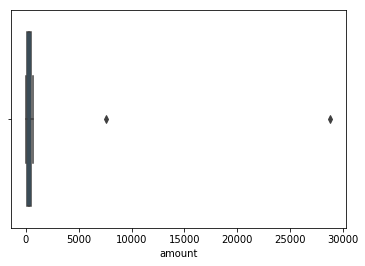

In [152]:
sns.boxplot(data[(data.user_id == 1001517) & (data.activity_type == 'Incoming')].amount)

In [170]:
data_user = data[(data.activity_type == 'Incoming')]


data_user[data_user.groupby(['user_id'])['amount'].apply(lambda x: np.abs(x - x.mean()) / x.std() > 3)][['user_id','amount']]
 

user_id         amount
0       1001517   28815.726712
19      1002039   34324.595626
72      1003411  114249.140256
299     1009990   46190.367444
338     1010526   51477.276746
465     1010744   73964.017697
466     1010744   68831.960248
525     1012874   36861.016159
555     1013451   36690.689061
759     1015278  144251.226109
760     1016207   44642.000923
841     1016716   97172.152068
925     1018025  129350.055434
1204    1021704   55937.792296
1207    1021704   90827.961995
1210    1021704   94882.218944
1214    1021704   61531.526949
1216    1021704   62264.282479
1219    1021704   71901.829573
1562    1023143   61398.807814
1565    1023143   66209.914886
1619    1024797   53345.699328
1624    1024797   34877.649938
1626    1024797   35754.652693
1629    1024797   33572.378095
1635    1024797   80442.850712
1888    1027960   60213.032352
2094    1034334   75814.798621
2293    1039572   59739.208760
2340    1041097   48650.837471
...         ...            ...
457113  9955024   57701.035757
457114  9955024   48912.484517
457173  9955826  105285.983916
457358  9959683  111367.056000
457419  9962064   64350.114398
457420  9962064   33537.896505
457425  9962064  108829.883544
457426  9962064   35192.827230
457760  9962091   42510.635152
457777  9962985   18826.949899
457826  9966259   80563.087312
457894  9968011   52244.903937
457994  9968083   61496.140526
458115  9969283  101294.511112
458192  9972184   60527.859345
458259  9975434   67948.257422
458304  9975631   16996.051350
458306  9975631   23576.817827
458376  9975715   36773.321491
458377  9975715   44890.644617
458380  9975715   42399.181212
458382  9975715   37365.187687
458896  9984200   66987.429978
459068  9986700   94633.307130
459081  9986700  106243.418160
459082  9986700   81229.284656
459085  9986700   80060.884838
459249  9989352  110600.096501
459732  9994228   81179.483105
459792  9996446   40696.790151

[3258 rows x 2 columns]

In [165]:
### The amount 28815.726712 is a red flag for the particular user. 

# b) A relative of user is defined as someone who shares same phone number. Find the set of relatives for all user_id’s.

<font color='blue'>  
    
Since relatives share phone numbers I first extracted all phone numbers for each user. Then I found the users of each phone number. Finally, I performed a set union of all the set of phone numbers which belong to a particular user. EG: It is a f(g(f)) operation.
</font>

In [3]:
users_phones = data.groupby(['user_id']).groups

user_phone_dict = {}

for key in users_phones:
    user_phone_dict[key] = data.loc[users_phones[key].values].user_phone_number.unique()

# We get all the phone numbers associated with every relatives, users 
user_phone_dict

{1001517: array(['409-242-7201', '279-587-7765', '696-429-7698', '261-891-2975',
        '329-791-3754', '550-972-5506', '331-840-5557', '794-622-4266',
        '938-456-5660', '231-513-2283', '278-173-1195', '330-513-7012',
        '345-941-3855', '818-813-3169', '432-782-3318', '934-375-8730',
        '797-706-2598', '205-761-4550'], dtype=object),
 1002039: array(['247-307-6213', '232-663-5991', '983-276-4709', '610-422-7213',
        '393-477-6827', '465-796-6581', '761-295-5834', '495-624-2154',
        '797-871-6084', '919-388-4704', '227-175-6747', '241-601-4627',
        '489-625-1531', '601-819-8711', '756-447-3703', '209-900-7550',
        '233-916-7786', '655-342-2004', '444-825-1674', '284-749-4661',
        '234-379-4265', '453-261-7225', '868-515-9823', '519-399-3587',
        '293-591-5559', '550-788-4473', '219-288-9199', '799-393-9323',
        '870-411-4568', '875-455-7992', '537-765-7748', '992-974-9373',
        '841-591-9898', '762-549-2900', '737-173-7800', '502-4

In [4]:
phones_user = data.groupby(['user_phone_number']).groups

phones_user_dict = {}

for key in phones_user:
    phones_user_dict[key] = data.loc[phones_user[key].values].user_id.unique()

# We get all the phone numbers associated with every relatives, users 
phones_user_dict

{'201-143-2235': array([1164341, 1417552, 1499725, 1606484, 2248222, 2643102, 3765393,
        3821998, 3974311, 4451015, 4891505, 4985072, 5281619, 5285585,
        5698416, 5702167, 6062401, 6345160, 6742701, 6745275, 6924841,
        7560771, 7594018, 7682098, 8043909, 8520583, 8658675, 8660387,
        8894841, 9496711, 9547074, 9905007]),
 '201-173-9347': array([1021704, 2398885, 3221126, 3729950, 3990083, 4252904, 4430978,
        4679732, 5259918, 5398610, 6062401, 6195345, 8820394, 9774211]),
 '201-232-6535': array([2086775, 2248222, 3367989, 5008658, 5429950, 6062401]),
 '201-244-9605': array([1070146, 1188345, 1625693, 1655593, 1698606, 3680567, 4802564,
        5106870, 8574263, 9067896, 9540301]),
 '201-256-6391': array([1817337, 3735468, 5422367, 5602669, 6136940, 6229776, 9057114,
        9571977, 9819321]),
 '201-282-4734': array([3796565, 4962738, 5559631, 6062401, 6923266, 7147504, 7746714]),
 '201-307-7616': array([1909566, 2915035, 5904365, 8914473]),
 '201-321-6608'

In [5]:
relatives = {}

for user_id in users_phones:
    
    relatives[user_id] = np.array([])

for user_id in users_phones:
    
    phones_list = user_phone_dict[user_id]
    for phones in phones_list:
        relatives[user_id] = np.union1d(relatives[user_id], phones_user_dict[phones])
    relatives[user_id] = relatives[user_id].astype(int)
    relatives[user_id] = np.delete(relatives[user_id], np.where(relatives[user_id] == user_id))

In [6]:
relatives

{1001517: array([1034880, 1039572, 1063451, 1074844, 1076312, 1080594, 1096821,
        1117432, 1136804, 1178166, 1188345, 1190469, 1237995, 1253664,
        1260427, 1261944, 1281428, 1282785, 1352092, 1360919, 1372130,
        1392582, 1395203, 1442653, 1447636, 1487234, 1494876, 1546536,
        1551519, 1606484, 1651215, 1655593, 1742022, 1782394, 1815777,
        1844120, 1847952, 1848157, 1883917, 1901748, 1907138, 1970242,
        1971745, 2033596, 2042062, 2045388, 2057149, 2095830, 2155488,
        2213934, 2233072, 2242313, 2281827, 2282335, 2297947, 2302817,
        2348189, 2355376, 2361490, 2415654, 2429333, 2466986, 2482103,
        2485559, 2534935, 2537233, 2551367, 2645032, 2659973, 2692753,
        2718825, 2793334, 2837670, 2852771, 2858172, 2917867, 2955127,
        2992136, 3022056, 3063959, 3090144, 3104808, 3107651, 3139221,
        3144820, 3193398, 3232365, 3235500, 3252372, 3262056, 3267601,
        3312734, 3361856, 3375553, 3380360, 3382588, 3593226, 363584

### c) When a transaction happens among relatives, call it circulatory (among relatives) transaction. Create a binary feature if a transaction is circulatory transaction. 

#### We check if there are any circulatory transactions . If a circulatory transaction happens, then the user_id will be in counter_party_id

In [11]:
np.setxor1d(list(data['counter_party_phone_number']), list(data['user_phone_number']))

array(['201-143-2235', '201-173-9347', '201-232-6535', ...,
       '999-861-5590', '999-897-2939', 'nan'], dtype='<U32')

In [15]:
data.loc[data['counter_party'].isin(phones_user_dict['201-143-2235'])]


Empty DataFrame
Columns: [Unnamed: 0, user_id, date, trx_type, activity_type, counter_party, amount, user_phone_number, counter_party_phone_number, Y]
Index: []

In [16]:
phones_user_dict['201-143-2235']

array([1164341, 1417552, 1499725, 1606484, 2248222, 2643102, 3765393,
       3821998, 3974311, 4451015, 4891505, 4985072, 5281619, 5285585,
       5698416, 5702167, 6062401, 6345160, 6742701, 6745275, 6924841,
       7560771, 7594018, 7682098, 8043909, 8520583, 8658675, 8660387,
       8894841, 9496711, 9547074, 9905007])

In [10]:
np.intersect1d(data['counter_party'], data['user_id'])

array([2868178, 6770270])

In [11]:
np.intersect1d(relatives[2868178],data[data.counter_party == 2868178].user_id)

array([], dtype=int64)

In [12]:
np.intersect1d(relatives[6770270],data[data.counter_party == 6770270].user_id)

array([], dtype=int64)

<font color='red'>  **It seems there are no circulatory transactions. Let us move on and hold that thought.**  </font> 

#### This there are only two user_ids which can have circulatory transactions . But we found they have no circulatory transactions. The code to generate the features should be as follows.

In [13]:
def isrelative(id1 , id2):
    try:
        if id2 in relatives[id1]:
            return True
        else:
            return False
    except:
        return False

In [14]:
data['is_circulatory'] = data.apply(lambda row: isrelative(row['user_id'],row['counter_party']), axis=1)

### d ) Suppose that you would like to track weekly incoming (from counterparty to user’s account) and outgoing (from user’s account to counterparty’s account) amount (i.e. sum of weekly amount). If this amount is more than \$100,000, then an alert should be generated. Create features  using these logics. (5 points)

##### Unmelt the sliced dataframe by the activity_type with sum on amount 

In [15]:
data_new = data[['user_id','date','activity_type','amount','Y']] 
data_new = data_new.pivot_table(index=['user_id','date','Y'], columns = 'activity_type', values = 'amount', aggfunc = np.sum).reset_index()

In [16]:
data_new.shape

(351287, 5)

#### Add a variable week and then groupby (user_id and week) to perform cumulative sum

In [17]:
data_new['week'] = data_new['date'].dt.week
data_new = data_new.fillna(0)
data_new['Incoming_new'] = data_new.groupby(['user_id','week'])['Incoming'].cumsum()
data_new['Outgoing_new'] = data_new.groupby(['user_id','week'])['Outgoing'].cumsum()
data_new.drop(columns=['Incoming','Outgoing'],  inplace=True)

In [18]:
# Sanity Check

data_new

activity_type  user_id       date  Y  week  Incoming_new   Outgoing_new
0              1001517 1971-02-05  0     5    116.239215       0.000000
1              1001517 1971-03-11  0    10    608.308096       0.000000
2              1001517 1971-04-06  0    14    391.071690       0.000000
3              1001517 1971-05-05  0    18    302.650516       0.000000
4              1001517 1971-05-10  0    19     34.903677       0.000000
5              1001517 1971-05-17  0    20    670.278876       0.000000
6              1001517 1971-06-16  0    24    414.361427       0.000000
7              1001517 1971-06-17  0    24  29230.088138       0.000000
8              1001517 1971-06-21  0    25    282.714316       0.000000
9              1001517 1971-08-03  0    31    401.841054       0.000000
10             1001517 1971-08-10  0    32      0.417913       0.000000
11             1001517 1971-09-13  0    37      0.000000   75919.208014
12             1001517 1971-10-18  0    42     80.892363       0.000000
13             1001517 1971-10-25  0    43      1.743121       0.000000
14             1001517 1971-12-13  0    50   7578.565233    3050.378441
15             1001517 1971-12-20  0    51    332.667576       0.000000
16             1001517 1971-12-31  0    52    233.212383       0.000000
17             1002039 1971-01-05  0     1    189.969379       0.000000
18             1002039 1971-01-06  0     1    781.093210       0.000000
19             1002039 1971-01-07  0     1    781.093210    2573.572454
20             1002039 1971-01-14  0     2     37.068458       0.000000
21             1002039 1971-01-18  0     3      0.000000   28197.846364
22             1002039 1971-02-10  0     6    666.319361       0.000000
23             1002039 1971-03-10  0    10      0.000000   11584.327721
24             1002039 1971-03-12  0    10    185.112030   11584.327721
25             1002039 1971-03-29  0    13     24.976805       0.000000
26             1002039 1971-04-23  0    16    780.545969       0.000000
27             1002039 1971-04-26  0    17    694.730598       0.000000
28             1002039 1971-05-05  0    18      0.000000   28168.443611
29             1002039 1971-05-18  0    20    722.104653       0.000000
...                ...        ... ..   ...           ...            ...
351257         9997845 1971-10-29  0    43      0.000000     160.055011
351258         9997845 1971-11-01  0    44      0.000000   39653.608632
351259         9997845 1971-11-05  0    44      0.000000   39941.623803
351260         9997845 1971-11-08  0    45      0.000000   42110.192389
351261         9997845 1971-11-16  0    46      0.000000   78404.727190
351262         9997845 1971-11-25  0    47      0.000000    1251.276484
351263         9997845 1971-12-01  0    48      0.000000   28593.779941
351264         9997845 1971-12-30  0    52      0.000000    1273.597130
351265         9999278 1971-01-07  0     1  81376.879561       0.000000
351266         9999278 1971-01-21  0     3      0.000000     422.868595
351267         9999278 1971-02-19  0     7      0.000000   98380.658336
351268         9999278 1971-02-23  0     8  17202.518284       0.000000
351269         9999278 1971-03-08  0    10      0.000000      76.541070
351270         9999278 1971-03-22  0    12      0.000000    2885.313332
351271         9999278 1971-04-22  0    16      0.000000    9718.186961
351272         9999278 1971-05-27  0    21   3129.791775       0.000000
351273         9999278 1971-06-02  0    22  19584.831887       0.000000
351274         9999278 1971-06-18  0    24      0.000000     272.998539
351275         9999278 1971-06-28  0    26      0.000000   41658.353262
351276         9999278 1971-07-26  0    30   5736.827237       0.000000
351277         9999278 1971-08-23  0    34      0.000000   12880.944586
351278         9999278 1971-10-07  0    40      0.000000   37691.317686
351279         9999278 1971-10-11  0    41  36381.380392       0.000000
351280         9999278 1971-10-19  0    

### e) Addition to features in d), you would like to use features which tracks weekly number of transaction by “trx_type” and “activity_type”. Create features which uses this logic. (5 points)

#### Here I make user of the pivot_table where I pivot with respect to the trx_type and activity_type separately. Then create another variable that keeos the count of weekly incoming 

In [19]:
data_trx =  data[['user_id','date','trx_type']] 

unique_trx = data.trx_type.unique()
data_trx.shape

(459995, 3)

In [20]:
data_trx = data_trx.pivot_table(index=['user_id','date'] , columns = 'trx_type' , aggfunc = len, fill_value = 0).reset_index()

data_trx.shape

(350869, 8)

In [21]:
data_trx.tail()

trx_type  user_id       date  ACH  Cash  Check  Credit_Card  Debit_Card  Wire
350864    9999278 1971-11-15    1     0      0            0           0     0
350865    9999278 1971-11-24    1     0      0            0           0     0
350866    9999278 1971-12-13    1     0      0            0           0     0
350867    9999278 1971-12-17    1     0      0            0           0     0
350868    9999278 1971-12-23    0     0      1            0           0     0

In [22]:
data_trx['week'] = data_trx['date'].dt.week

for trx in unique_trx:
    print(trx)
    data_trx[trx + '_count'] = data_trx.groupby(['user_id','week'])[trx].cumsum()
    data_trx.drop([trx], axis=1, inplace=True)

ACH
Credit_Card
Check
Debit_Card
Cash
Wire


In [23]:
data_trx

trx_type  user_id       date  week  ACH_count  Credit_Card_count  Check_count  \
0         1001517 1971-02-05     5          0                  1            0   
1         1001517 1971-03-11    10          0                  1            0   
2         1001517 1971-04-06    14          0                  1            0   
3         1001517 1971-05-05    18          0                  1            0   
4         1001517 1971-05-10    19          0                  1            0   
5         1001517 1971-05-17    20          0                  1            0   
6         1001517 1971-06-16    24          0                  1            0   
7         1001517 1971-06-17    24          1                  1            0   
8         1001517 1971-06-21    25          0                  1            0   
9         1001517 1971-08-03    31          0                  1            0   
10        1001517 1971-08-10    32          0                  1            0   
11        1001517 1971-09-13    37          1                  0            0   
12        1001517 1971-10-18    42          0                  1            0   
13        1001517 1971-10-25    43          0                  1            0   
14        1001517 1971-12-13    50          2                  0            0   
15        1001517 1971-12-20    51          0                  1            0   
16        1001517 1971-12-31    52          0                  1            0   
17        1002039 1971-01-05     1          0                  1            0   
18        1002039 1971-01-06     1          0                  2            0   
19        1002039 1971-01-07     1          1                  2            0   
20        1002039 1971-01-14     2          0                  1            0   
21        1002039 1971-01-18     3          1                  0            0   
22        1002039 1971-02-10     6          0                  1            0   
23        1002039 1971-03-10    10          1                  0            0   
24        1002039 1971-03-12    10          1                  1            0   
25        1002039 1971-03-29    13          0                  1            0   
26        1002039 1971-04-23    16          0                  1            0   
27        1002039 1971-04-26    17          0                  1            0   
28        1002039 1971-05-05    18          1                  0            0   
29        1002039 1971-05-18    20          0                  1            0   
...           ...        ...   ...        ...                ...          ...   
350839    9997845 1971-10-29    43          0                  0            0   
350840    9997845 1971-11-01    44          1                  0            0   
350841    9997845 1971-11-05    44          1                  0            0   
350842    9997845 1971-11-08    45          1                  0            0   
350843    9997845 1971-11-16    46          1                  0            0   
350844    9997845 1971-11-25    47          0                  0            0   
350845    9997845 1971-12-01    48          1                  0            0   
350846    9997845 1971-12-30    52          0                  0            0   
350847    9999278 1971-01-07     1          1                  0            0   
350848    9999278 1971-01-21     3          0                  0            0   
350849    9999278 1971-02-19     7          1                  0            0   
350850    9999278 1971-02-23     8          1                  0            0   
350851    9999278 1971-03-08    10          0                  0            0   
350852    9999278 1971-03-22    12          1                  0            0   
350853    9999278 1971-04-22    16          1                  0            0   
350854    9999278 1971-05-27    21          1                  0            0   
350855    9999278 1971-06-02    22          1                  0            0   
350856    9999278 1971-06-18   

In [24]:
data_act =  data[['user_id','date','activity_type']] 
data_act = data_act.pivot_table(index=['user_id','date'] , columns = 'activity_type' , aggfunc = len, fill_value = 0).reset_index()
data_act['week'] = data_act['date'].dt.week
data_act['inc_count'] = data_act.groupby(['user_id','week'])['Incoming'].cumsum()
data_act['out_count'] = data_act.groupby(['user_id','week'])['Outgoing'].cumsum()

data_act.drop(columns=['Incoming','Outgoing'],  inplace=True)

In [25]:
data_act

activity_type  user_id       date  week  inc_count  out_count
0              1001517 1971-02-05     5          1          0
1              1001517 1971-03-11    10          1          0
2              1001517 1971-04-06    14          1          0
3              1001517 1971-05-05    18          1          0
4              1001517 1971-05-10    19          1          0
5              1001517 1971-05-17    20          1          0
6              1001517 1971-06-16    24          1          0
7              1001517 1971-06-17    24          2          0
8              1001517 1971-06-21    25          1          0
9              1001517 1971-08-03    31          1          0
10             1001517 1971-08-10    32          1          0
11             1001517 1971-09-13    37          0          1
12             1001517 1971-10-18    42          1          0
13             1001517 1971-10-25    43          1          0
14             1001517 1971-12-13    50          1          1
15             1001517 1971-12-20    51          1          0
16             1001517 1971-12-31    52          1          0
17             1002039 1971-01-05     1          1          0
18             1002039 1971-01-06     1          2          0
19             1002039 1971-01-07     1          2          1
20             1002039 1971-01-14     2          1          0
21             1002039 1971-01-18     3          0          1
22             1002039 1971-02-10     6          1          0
23             1002039 1971-03-10    10          0          1
24             1002039 1971-03-12    10          1          1
25             1002039 1971-03-29    13          1          0
26             1002039 1971-04-23    16          1          0
27             1002039 1971-04-26    17          1          0
28             1002039 1971-05-05    18          0          1
29             1002039 1971-05-18    20          1          0
...                ...        ...   ...        ...        ...
350839         9997845 1971-10-29    43          0          1
350840         9997845 1971-11-01    44          0          2
350841         9997845 1971-11-05    44          0          3
350842         9997845 1971-11-08    45          0          1
350843         9997845 1971-11-16    46          0          1
350844         9997845 1971-11-25    47          0          1
350845         9997845 1971-12-01    48          0          1
350846         9997845 1971-12-30    52          0          1
350847         9999278 1971-01-07     1          1          0
350848         9999278 1971-01-21     3          0          1
350849         9999278 1971-02-19     7          0          1
350850         9999278 1971-02-23     8          1          0
350851         9999278 1971-03-08    10          0          1
350852         9999278 1971-03-22    12          0          1
350853         9999278 1971-04-22    16          0          1
350854         9999278 1971-05-27    21          1          0
350855         9999278 1971-06-02    22          1          0
350856         9999278 1971-06-18    24          0          1
350857         9999278 1971-06-28    26          0          1
350858         9999278 1971-07-26    30          1          0
350859         9999278 1971-08-23    34          0          1
350860         9999278 1971-10-07    40          0          1
350861         9999278 1971-10-11    41          1          0
350862         9999278 1971-10-19    42          0          1
350863         9999278 1971-10-25    43          1          0
350864         9999278 1971-11-15    46          0          1
350865         9999278 1971-11-24    47          0          1
350866         9999278 1971-12-13    50          1          0
350867         9999278 1971-12-17    50          2          0
350868         9999278 1971-12-23    51          0          1

[350869 rows x 5 columns]

### f) Using the features as created in part (c), (d) and (e), build a statistical machine learning model to detect the suspicious money laundering cases. (To build a model, data (features, and Y) can be aggregated at [“user_id”, “date”] level. ) Report model performance using a relevant metric (and why you would choose this metric?) (8+2 points)

In [26]:
data.groupby('Y').count()

Unnamed: 0  user_id    date  trx_type  activity_type  counter_party  \
Y                                                                        
0      459276   459276  459276    459276         459276         459276   
1         719      719     719       719            719            719   

   amount  user_phone_number  counter_party_phone_number  is_circulatory  
Y                                                                         
0  459276             459276                       10412          459276  
1     719                719                          21             719

#### Let us merge and create the dataset. We ignore feature generated in (c) as there are no circulatory transactions.

In [102]:
df = pd.concat([data_new[['Y','Incoming_new','Outgoing_new']], data_trx[['ACH_count', 'Credit_Card_count', 'Check_count', 'Debit_Card_count', 'Cash_count', 'Wire_count']], data_act[['inc_count','out_count']]], axis=1, join='inner')

In [103]:
df.reset_index(inplace=True, drop=True)

In [104]:
df.head()

Y  Incoming_new  Outgoing_new  ACH_count  Credit_Card_count  Check_count  \
0  0    116.239215           0.0          0                  1            0   
1  0    608.308096           0.0          0                  1            0   
2  0    391.071690           0.0          0                  1            0   
3  0    302.650516           0.0          0                  1            0   
4  0     34.903677           0.0          0                  1            0   

   Debit_Card_count  Cash_count  Wire_count  inc_count  out_count  
0                 0           0           0          1          0  
1                 0           0           0          1          0  
2                 0           0           0          1          0  
3                 0           0           0          1          0  
4                 0           0           0          1          0

In [105]:
df.describe()

Y  Incoming_new  Outgoing_new      ACH_count  \
count  350869.000000  3.508690e+05  3.508690e+05  350869.000000   
mean        0.002049  7.741344e+03  1.283929e+04       0.558385   
std         0.045222  2.127596e+04  3.424925e+04       1.078588   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000000  0.000000e+00  0.000000e+00       0.000000   
50%         0.000000  0.000000e+00  9.205371e+02       0.000000   
75%         0.000000  1.849793e+03  8.442858e+03       1.000000   
max         1.000000  2.255055e+06  2.975321e+06      75.000000   

       Credit_Card_count    Check_count  Debit_Card_count     Cash_count  \
count      350869.000000  350869.000000     350869.000000  350869.000000   
mean            0.484913       0.138961          1.032260       0.010217   
std             1.120751       0.397551          1.682799       0.110115   
min             0.000000       0.000000          0.000000       0.000000   
25%             0.000000       0.000000          0.000000       0.000000   
50%             0.000000       0.000000          1.000000       0.000000   
75%             1.000000       0.000000          1.000000       0.000000   
max            25.000000       7.000000         31.000000       6.000000   

          Wire_count      inc_count      out_count  
count  350869.000000  350869.000000  350869.000000  
mean        0.001123       0.746809       1.479051  
std         0.034415       1.233455       1.978975  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       1.000000  
75%         0.000000       1.000000       2.000000  
max         3.000000      62.000000      77.000000

<font color='blue'>**The dataset has two Numeric Features (Incoming and Outgoing) and the rest are count features. I selected logistic regression as the dataset has two classes.  The focus of my analysis is more towards addressing data imbalance problem.  ** </font>

In [106]:
df.groupby('Y').count()

Incoming_new  Outgoing_new  ACH_count  Credit_Card_count  Check_count  \
Y                                                                          
0        350150        350150     350150             350150       350150   
1           719           719        719                719          719   

   Debit_Card_count  Cash_count  Wire_count  inc_count  out_count  
Y                                                                  
0            350150      350150      350150     350150     350150  
1               719         719         719        719        719

<font color='blue'> **Firstly, this is a case of extreme data imbalance. With Frauds 0.20 % of the dataset algorithms are prone to overfit.**
</font>

In [107]:
Frauds = 719
No_frauds = 350150

print('Percent of frauds is: ' + str(Frauds/(Frauds + No_frauds)*100))

Percent of frauds is: 0.20491978487697687


#### The shape reduces due to pivot where we aggregate by ('user_id','date') . But we see the 719 instances of the fraud cases are preserved. 

Text(0.5,1,'Class Distributions \n (0: No Fraud || 1: Fraud)')

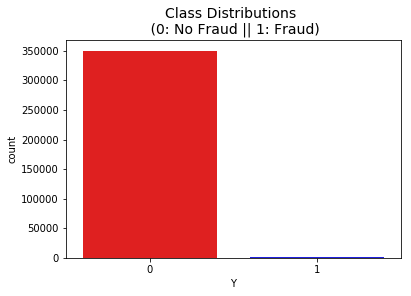

In [108]:
colors = ["red", "blue"]

sns.countplot('Y', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

#### Distribution of the Incoming and Outgoing Transactions amount

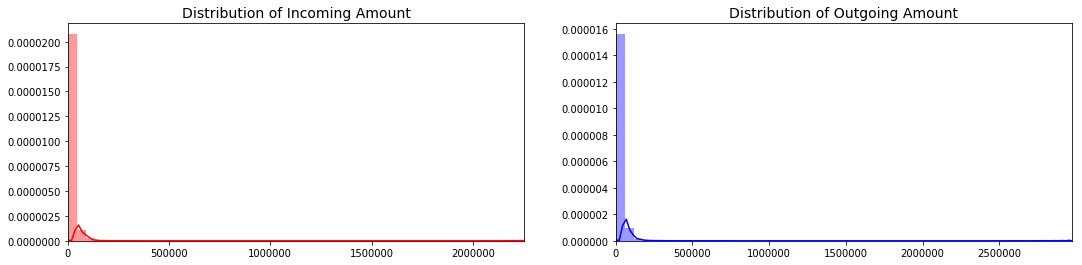

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

inc_val = df['Incoming_new'].values
out_val = df['Outgoing_new'].values


sns.distplot(inc_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Incoming Amount', fontsize=14)
ax[0].set_xlim([min(inc_val), max(inc_val)])


sns.distplot(out_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Outgoing Amount', fontsize=14)
ax[1].set_xlim([min(out_val), max(out_val)])


plt.show()

### Feature standardization. We standardize the Incoming and Outgoing Amounts. Since the data has a lot of has a high positive skew, we apply a power transform. 

In [110]:
df_orig = df.copy()

pt = PowerTransformer()

pt.fit( df.ix[:, 1:].values )

df.ix[:, 1:] = pt.transform(df.ix[:, 1:].values ) 


#df['scaled_outging'] = pt.fit(df['Outgoing_new'].values.reshape(-1,1))

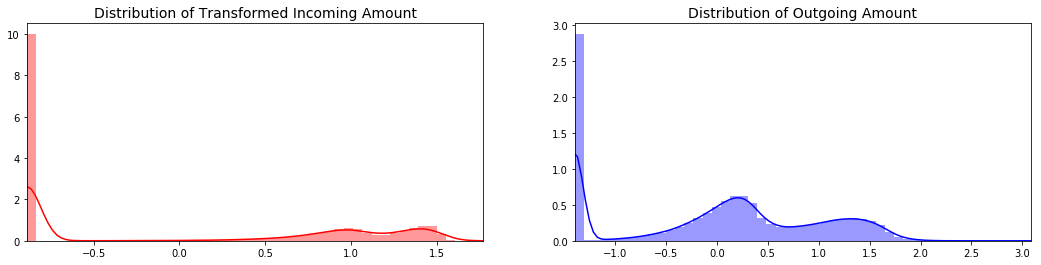

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

inc_val = df['Incoming_new'].values
out_val = df['Outgoing_new'].values


sns.distplot(inc_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transformed Incoming Amount', fontsize=14)
ax[0].set_xlim([min(inc_val), max(inc_val)])


sns.distplot(out_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Outgoing Amount', fontsize=14)
ax[1].set_xlim([min(out_val), max(out_val)])


plt.show()

# Accuracy is a poor metric hence we stick with F1 score, Precision and Recall and the Confusion matrix.  

## Now to treat the data imbalance problem we perform Random under-sampling and oversampling by SMOTE.

In [112]:
classifier = LogisticRegression

In [113]:
X = df.drop('Y', axis = 1)
y = df['Y']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [115]:
X_train.shape

(263151, 10)

Text(0.5,1,'Distribution of Classes')

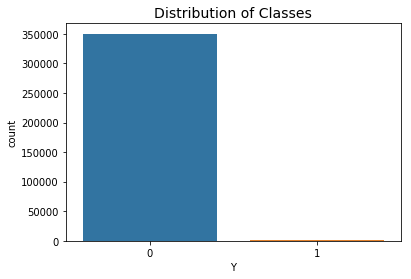

In [116]:
sns.countplot(df.Y)
plt.title('Distribution of Classes', fontsize=14)


### Build a Logistic Regression without any treatment for imbalanced data

In [42]:
pipeline = make_pipeline(classifier(random_state=42))
model = pipeline.fit(X_train, y_train)
prediction = model.predict(X_test)

### Build model with SMOTE imblearn

In [43]:
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier(random_state=42))
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

# Build model with undersampling

In [44]:
nearmiss_pipeline = make_pipeline_imb(NearMiss(random_state=42), classifier(random_state=42))
nearmiss_model = nearmiss_pipeline.fit(X_train, y_train)
nearmiss_prediction = nearmiss_model.predict(X_test)

### Check the data distribution of all the models 

In [45]:
print()
print("Logistic Regression data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))
X_nearmiss, y_nearmiss = NearMiss().fit_sample(X, y)
print("NearMiss data distribution: {}".format(Counter(y_nearmiss)))


Logistic Regression data distribution: Counter({0: 350150, 1: 719})
SMOTE data distribution: Counter({0: 350150, 1: 350150})
NearMiss data distribution: Counter({0: 719, 1: 719})


In [46]:
print()
print('normal Pipeline Score {}'.format(pipeline.score(X_test, y_test)))
print('SMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))
print('NearMiss Pipeline Score {}'.format(nearmiss_pipeline.score(X_test, y_test)))


normal Pipeline Score 0.9981075719920655
SMOTE Pipeline Score 0.7595932419799813
NearMiss Pipeline Score 0.27738890535579924


In [47]:
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f1: {}".format(f1_score(true_value, pred)))

In [48]:
print('Training scores:')
print_results("Logistic Regression No Treatment: classification", y_train,  model.predict(X_train))
print()
print_results("SMOTE classification", y_train, smote_model.predict(X_train))
print()
print_results("NearMiss classification", y_train, nearmiss_model.predict(X_train))

Training scores:
Logistic Regression No Treatment: classification
accuracy: 0.9978985449418775
precision: 0.0
recall: 0.0
f1: 0.0

SMOTE classification
accuracy: 0.7610193387066742
precision: 0.0071474881006973546
recall: 0.8173598553345389
f1: 0.014171055931778281

NearMiss classification
accuracy: 0.27779867832537214
precision: 0.002629962676577584
recall: 0.9059674502712477
f1: 0.005244700340225072


In [49]:
print('Testing Scores:')
print_results("Logistic Regression No Treatment: classification", y_test, prediction)
print()
print_results("SMOTE classification", y_test, smote_prediction)
print()
print_results("NearMiss classification", y_test, nearmiss_prediction)

Testing Scores:
Logistic Regression No Treatment: classification
accuracy: 0.9981075719920655
precision: 0.0
recall: 0.0
f1: 0.0

SMOTE classification
accuracy: 0.7595932419799813
precision: 0.006277138002643005
recall: 0.8012048192771084
f1: 0.012456682588742156

NearMiss classification
accuracy: 0.27738890535579924
precision: 0.0023457917440725465
recall: 0.8975903614457831
f1: 0.004679354311915081


# SMOTE seems to have better results on test data. We check with cross validation. We did cross-validation while sampling. 

In [50]:
 
kf = KFold(n_splits=5, random_state=42)
accuracy = []
precision = []
recall = []
f1 = []
auc = []

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


for train, test in kf.split(X_train, y_train):
    pipeline = make_pipeline_imb(SMOTE(sampling_strategy='minority'), rand_log_reg)
    
    
    # print("TRAIN:", train, "TEST:", test)
    model = pipeline.fit(X_train[train], y_train[train])
    best_est = rand_log_reg.best_estimator_
    prediction = model.predict(X_train[test])

    accuracy.append(pipeline.score(X_train[test], y_train[test]))
    precision.append(precision_score(y_train[test], prediction))
    recall.append(recall_score(y_train[test], prediction))
    f1.append(f1_score(y_train[test], prediction))
    auc.append(roc_auc_score(y_train[test], prediction))

print()
print("SMOTE cross validation scores 5-fold:")
print("accuracy: {}".format(np.mean(accuracy)))
print("precision: {}".format(np.mean(precision)))
print("recall: {}".format(np.mean(recall)))
print("f1: {}".format(np.mean(f1)))
print()


SMOTE cross validation scores 5-fold:
accuracy: 0.7627521816819407
precision: 0.00712122598565969
recall: 0.8078428621946336
f1: 0.014117573714132057



In [52]:
# The training and test errors for SMOTE once again to compare with cross-validataion results. 

print()
print_results("SMOTE classification training:", y_train, smote_model.predict(X_train))
print()
print_results("SMOTE classification testing:", y_test, smote_model.predict(X_test))


SMOTE classification training:
accuracy: 0.7610193387066742
precision: 0.0071474881006973546
recall: 0.8173598553345389
f1: 0.014171055931778281

SMOTE classification testing:
accuracy: 0.7595932419799813
precision: 0.006277138002643005
recall: 0.8012048192771084
f1: 0.012456682588742156


# We see that the training and cross-validation errors are comparatively lower.

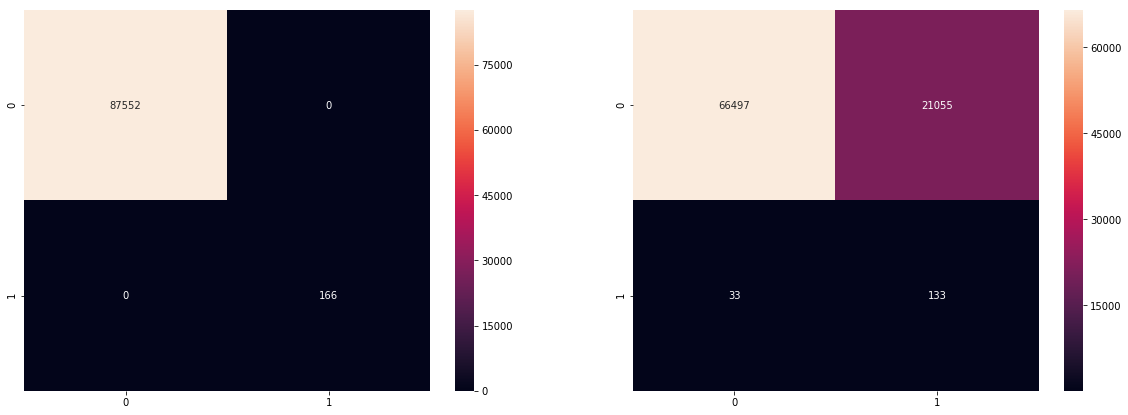

In [53]:
# Let us see the confusion matrix to find how many Fraud cases were correctly detected

fig, ax = plt.subplots(1, 2,figsize=(20,7))

sns.heatmap(confusion_matrix(y_test,y_test), ax=ax[0] , annot=True, fmt = 'g')

sns.heatmap(confusion_matrix(y_test,smote_model.predict(X_test)), ax=ax[1], annot=True, fmt = 'g')
plt.show()


### 133 of 166 fraud cases were detected correctly. 

# Summary 

* Performed pre-processing by standardizing the data with power transform, since the data has high positive skew.

* Treated data imbalance problem by SMOTE over-sampling strategy.

* Chose logistic regression since this is a binary classification problem. 

* Performed cross-validation and found l1 regularization with a parameter 0.1 gives us the best result.

* Selected F1 score, precision, recall as metrics and the confusion matrix for visualization.

* The precision is pretty low as the number of False positives are high. Which means that more transactions that are not fraud can be flagged as fraud. There is a


# APPENDIX : Extended analysis 

* We do some more analysis to find any patterns 
* We check if any covariates has any incluence on the target and whether a non-linear model is better. 


In [117]:
df_orig = df_orig.sample(frac=1)

# amount of fraud classes 719 rows.
fraud_df = df_orig.loc[df['Y'] == 1]
non_fraud_df = df_orig.loc[df['Y'] == 0][:Frauds]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

Y  Incoming_new   Outgoing_new  ACH_count  Credit_Card_count  \
83965   1      0.000000  100531.849079          2                  0   
316014  0      0.000000     503.546003          1                  0   
160336  0   1329.744531       0.000000          0                  0   
18010   0      0.000000     268.946873          0                  0   
185167  1   2956.510522   16328.259721          1                  0   

        Check_count  Debit_Card_count  Cash_count  Wire_count  inc_count  \
83965             0                 5           0           0          0   
316014            0                 0           0           0          0   
160336            1                 0           0           0          0   
18010             0                 3           0           0          0   
185167            0                 0           0           0          1   

        out_count  
83965           7  
316014          1  
160336          1  
18010           3  
185167          0

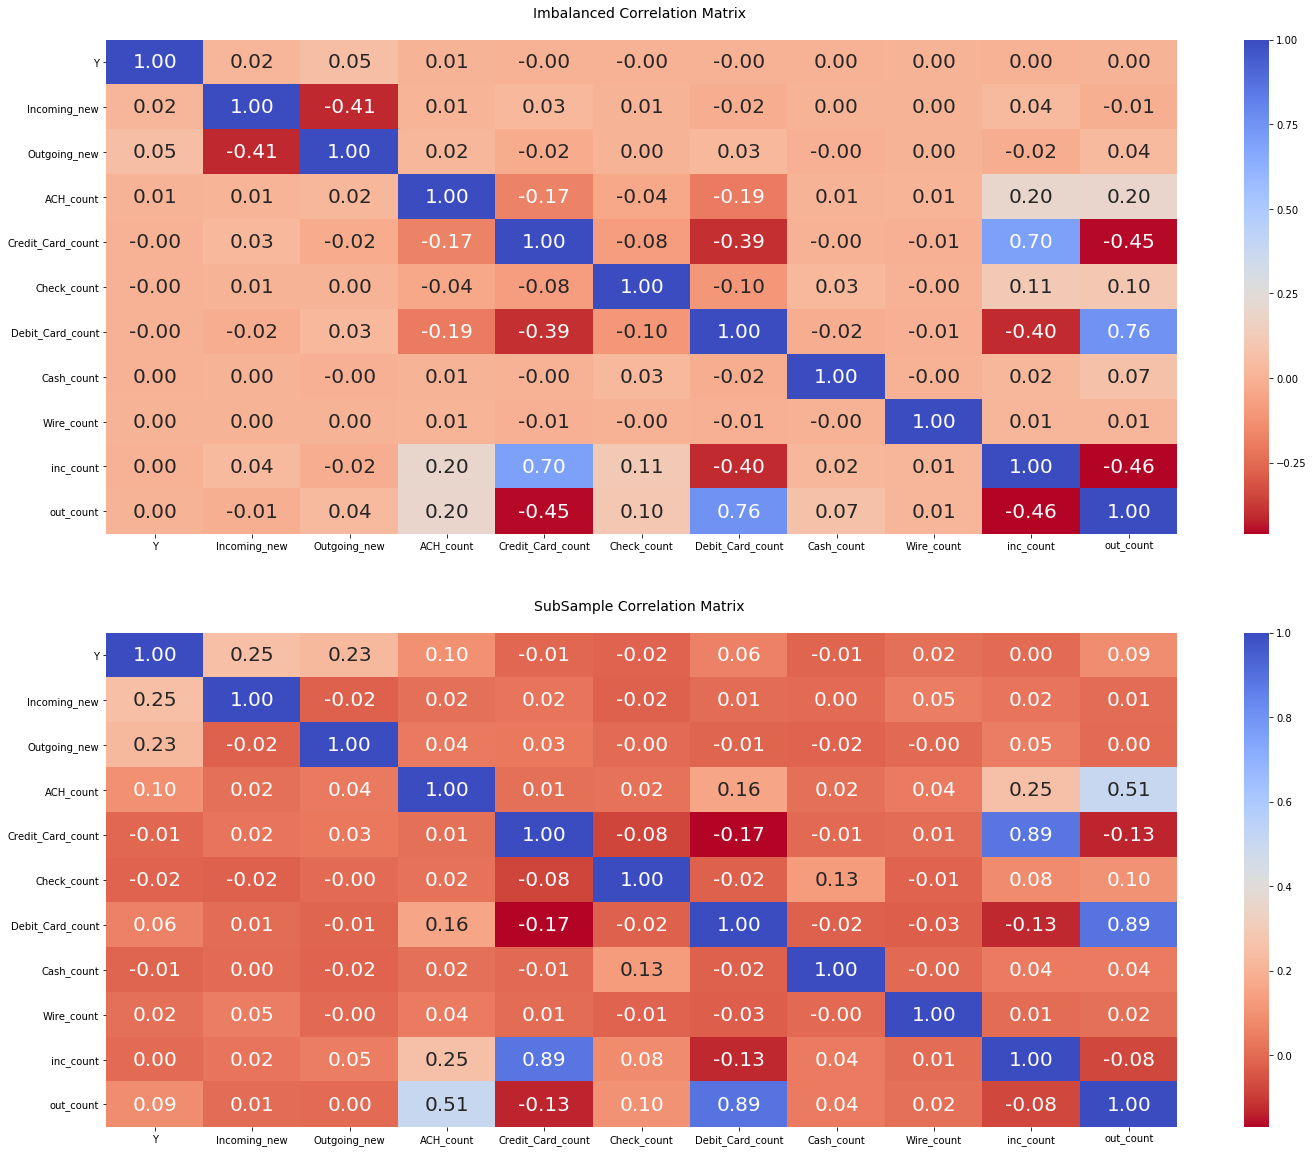

In [118]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1 , annot=True,   fmt = '.2f')
ax1.set_title("Imbalanced Correlation Matrix \n", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2, annot=True, fmt = '.2f')
ax2.set_title('SubSample Correlation Matrix \n', fontsize=14)
plt.show()

# From the subsample correlation matrix we find some key insights -

* Outgoing amount has a moderate effect on Fraud detection while the incoming amount has a very weak effect

* ACH transactions are more prone to be frauds and the rest have very low correlation

* More credit card transactions are incoming, while debit card transactions are outgoing

* Credit card transactions are negatively correlated with debit card transactions

# Logistic Regression coefficients 

In [120]:
list(df_orig.columns[1:])
best_est.coef_[0]

array([ 0.7721376 ,  1.54119318,  0.08599215, -0.16758872, -0.06063011,
       -0.08444279, -0.25566105, -0.03816076,  0.03232447,  0.03114704])

In [121]:
d = {'variable' : list(df_orig.columns[1:]), 'coefficients' : best_est.coef_[0]}
d = pd.DataFrame(data=d)
d

variable  coefficients
0       Incoming_new      0.772138
1       Outgoing_new      1.541193
2          ACH_count      0.085992
3  Credit_Card_count     -0.167589
4        Check_count     -0.060630
5   Debit_Card_count     -0.084443
6         Cash_count     -0.255661
7         Wire_count     -0.038161
8          inc_count      0.032324
9          out_count      0.031147

# Important parameters 

* Outgoing and Incoming amounts are major determinants for detecting fraud, followed by number of Cash and Credit card transactions


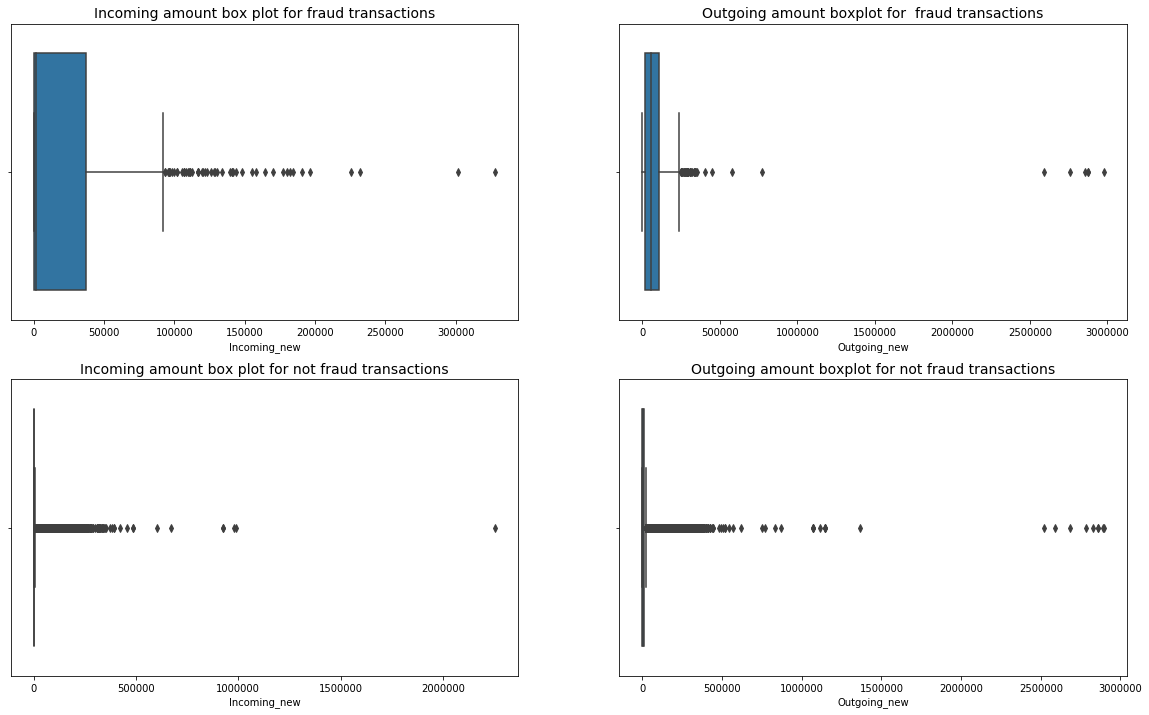

In [122]:
 
fig, ax = plt.subplots(2, 2,figsize=(20,12))

sns.boxplot(df_orig.Incoming_new[df.Y == 1] , ax=ax[0][0])
ax[0][0].set_title('Incoming amount box plot for fraud transactions', fontsize=14)
sns.boxplot(df_orig.Outgoing_new[df.Y == 1] , ax=ax[0][1])
ax[0][1].set_title('Outgoing amount boxplot for  fraud transactions', fontsize=14)
sns.boxplot(df_orig.Incoming_new[df.Y == 0] , ax=ax[1][0])
ax[1][0].set_title('Incoming amount box plot for not fraud transactions', fontsize=14)
sns.boxplot(df_orig.Outgoing_new[df.Y == 0] , ax=ax[1][1])
ax[1][1].set_title('Outgoing amount boxplot for not fraud transactions', fontsize=14)
plt.show()

###  We see that fraud transactions are larger in sum. Next, we check ACH counts as it has a positive coefficient. 

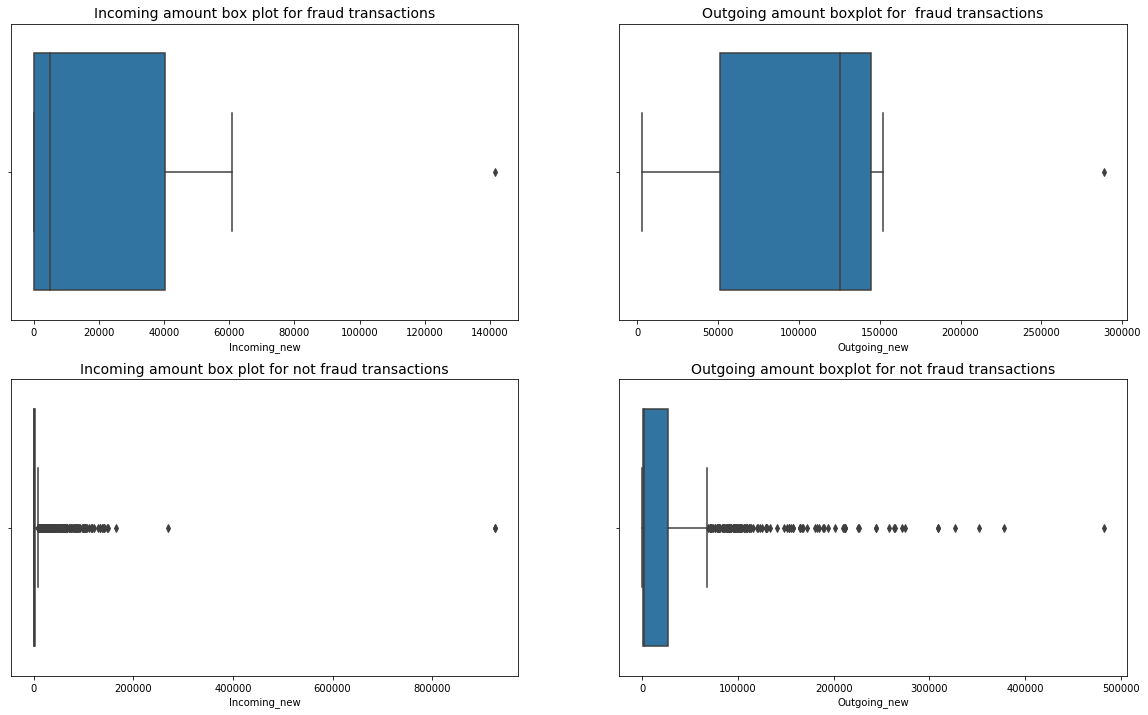

In [146]:
fig, ax = plt.subplots(2, 2,figsize=(20,12))

sns.boxplot(df_orig[(df_orig.Y==1) & (df_orig.ACH_count > 5)].Incoming_new , ax=ax[0][0])
ax[0][0].set_title('Incoming amount box plot for fraud transactions', fontsize=14)
sns.boxplot(df_orig[(df_orig.Y==1) & (df_orig.ACH_count > 5)].Outgoing_new, ax=ax[0][1])
ax[0][1].set_title('Outgoing amount boxplot for  fraud transactions', fontsize=14)
sns.boxplot(df_orig[(df_orig.Y==0) & (df_orig.ACH_count > 5)].Incoming_new, ax=ax[1][0])
ax[1][0].set_title('Incoming amount box plot for not fraud transactions', fontsize=14)
sns.boxplot(df_orig[(df_orig.Y==0) & (df_orig.ACH_count > 5)].Outgoing_new , ax=ax[1][1])
ax[1][1].set_title('Outgoing amount boxplot for not fraud transactions', fontsize=14)
plt.show()

### The range of transactions for out going amounts for ACH is higher for outgoing amounts than incoming amounts.

# Summary of insights from analysis

* Outgoing amount has a moderate effect on Fraud detection while the incoming amount has a very weak effect

* ACH transactions are more prone to be frauds and the rest have very low correlation

* More credit card transactions are incoming, while debit card transactions are outgoing

* Credit card transactions are negatively correlated with debit card transactions

* Outgoing and Incoming amounts are major determinants for detecting fraud, followed by number of Cash and Credit card transactions.

* The range of transactions for out going amounts for ACH is higher for outgoing amounts than incoming amounts.

# Selecting non-linear models 

* I applied non-linear Neural Network model to see if any improvements can be made. 

* We use SMOTE to handle the data imbalance 

# Neural Network Classifier

In [57]:
sm = SMOTE(ratio='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_sample( X_train,  y_train)
n_inputs = Xsm_train.shape[1]

nn_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

nn_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=100, shuffle=True, verbose=2)
nn_predictions = nn_model.predict( X_test, batch_size=200, verbose=0)
nn_fraud_predictions = nn_model.predict_classes(X_test, batch_size=200, verbose=0)


Train on 420156 samples, validate on 105040 samples
Epoch 1/100
 - 2s - loss: 0.4294 - acc: 0.7966 - val_loss: 0.4763 - val_acc: 0.7808
Epoch 2/100
 - 2s - loss: 0.3690 - acc: 0.8230 - val_loss: 0.4343 - val_acc: 0.8147
Epoch 3/100
 - 2s - loss: 0.3597 - acc: 0.8268 - val_loss: 0.4787 - val_acc: 0.8006
Epoch 4/100
 - 2s - loss: 0.3547 - acc: 0.8290 - val_loss: 0.4952 - val_acc: 0.7838
Epoch 5/100
 - 2s - loss: 0.3513 - acc: 0.8301 - val_loss: 0.4852 - val_acc: 0.7982
Epoch 6/100
 - 2s - loss: 0.3490 - acc: 0.8311 - val_loss: 0.4282 - val_acc: 0.8296
Epoch 7/100
 - 2s - loss: 0.3471 - acc: 0.8324 - val_loss: 0.4567 - val_acc: 0.8131
Epoch 8/100
 - 2s - loss: 0.3454 - acc: 0.8339 - val_loss: 0.4457 - val_acc: 0.8121
Epoch 9/100
 - 2s - loss: 0.3439 - acc: 0.8344 - val_loss: 0.4537 - val_acc: 0.8081
Epoch 10/100
 - 2s - loss: 0.3418 - acc: 0.8361 - val_loss: 0.4074 - val_acc: 0.8513
Epoch 11/100
 - 2s - loss: 0.3403 - acc: 0.8369 - val_loss: 0.4412 - val_acc: 0.8257
Epoch 12/100
 - 2s - l

Epoch 97/100
 - 2s - loss: 0.3113 - acc: 0.8543 - val_loss: 0.3382 - val_acc: 0.8757
Epoch 98/100
 - 2s - loss: 0.3112 - acc: 0.8550 - val_loss: 0.3604 - val_acc: 0.8689
Epoch 99/100
 - 2s - loss: 0.3114 - acc: 0.8546 - val_loss: 0.3930 - val_acc: 0.8411
Epoch 100/100
 - 2s - loss: 0.3110 - acc: 0.8545 - val_loss: 0.3815 - val_acc: 0.8505


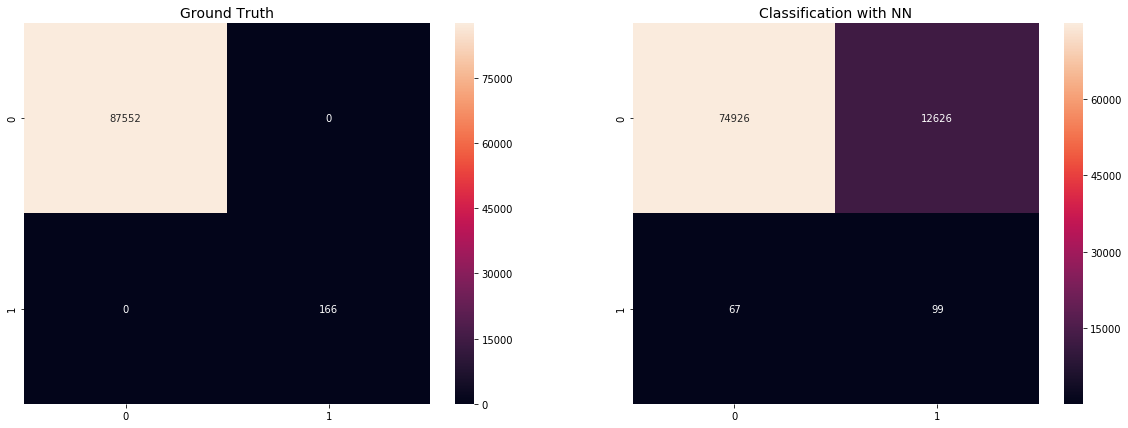

In [91]:
nn_smote = confusion_matrix(y_test, nn_fraud_predictions)
actual_cm = confusion_matrix(y_test, y_test)
labels = ['No Fraud', 'Fraud']

fig, ax = plt.subplots(1, 2,figsize=(20,7))

sns.heatmap(actual_cm, ax=ax[0] , annot=True, fmt = 'g')
ax[0].set_title('Ground Truth', fontsize=14)
sns.heatmap(nn_smote, ax=ax[1], annot=True, fmt = 'g')
ax[1].set_title('Classification with NN', fontsize=14)

plt.show()


In [148]:
print()
print_results("NN classification training:", y_train,  nn_model.predict_classes(X_train))
print()
print_results("NN classification testing:", y_test, nn_model.predict_classes(X_test))


NN classification training:
accuracy: 0.8572682604284232
precision: 0.01176812053088472
recall: 0.8065099457504521
f1: 0.023197753042754603

NN classification testing:
accuracy: 0.8552976584053444
precision: 0.007779960707269155
recall: 0.5963855421686747
f1: 0.015359553176634861


### Summary 

* We don't achieve any better performance with a Neural Network.

* The slight improvement of precision in test data comes at a heavy cost on recall. 

# Finishing Thoughts 

* There are a wide range of classification algorithms that can be explored to find the best result  

* SVM, Decision Trees and K-NN are the basic ones and more complex ones such as Random Forest, XGboost and more complex Neural Network with multiple layers may provide us with better results. 

